In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.insert(0, "../")

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import scipy as sp
import scipy.fftpack as fp
import scipy.signal as signal
from scipy.stats import norm
from scipy.fftpack import fft, ifft, dct, idct

import csv
import pandas as pd

# import pywt
from sklearn import datasets, decomposition, svm
from scipy import interpolate


In [8]:
def readVariableLength(filepath):
    data = pd.read_csv(filepath, sep=" ", header=None)         
    return np.array(data.iloc[:,1:]), np.array(data.iloc[:,0], dtype=np.int32)
    
def znorm(data):
    newData = [0] * len(data)
    for i in range(len(data)):
        mean = np.mean(data[i])
        std = np.std(data[i])
        newData[i] = ((data[i] - mean) / std)
               
    return newData  

def paa_transform(ts, n_pieces, repeat=True):
    splitted = np.array_split(ts, n_pieces)
    mean = np.asarray(map(lambda xs: xs.mean(axis = 0), splitted))
    
    n = len(ts)
    m = n / n_pieces
    
    if (repeat) :
        means_ext = np.repeat(mean, m, axis = 0)
        means = means_ext

    return np.array(means)

def sax_transform(ts, n_pieces, alphabet):
    alphabet_sz = len(alphabet)
    thrholds = norm.ppf(np.linspace(1./alphabet_sz, 
                                    1-1./alphabet_sz, 
                                    alphabet_sz-1))
    def translate(ts_values):
        return np.asarray([(alphabet[0] if ts_value < thrholds[0]
                else (alphabet[-1] if ts_value > thrholds[-1]
                      else alphabet[np.where(thrholds <= ts_value)[0][-1]+1]))
                           for ts_value in ts_values])

    print("TS", ts)
    paa_ts = paa_transform(ts, n_pieces, False)
    print("PAA", paa_ts)
    return np.apply_along_axis(translate, 0, paa_ts), thrholds


def translate(ts_values, alphabet, thrholds):
    return np.asarray([(0 if ts_value < thrholds[0]
            else (len(alphabet)-1 if ts_value > thrholds[-1]
                  else np.where(thrholds <= ts_value)[0][-1]+1))
                       for ts_value in ts_values])


def dft(ts, n_pieces):    
    return fp.rfft(ts)[0:n_pieces+1]       
        
def idft(ts, originalSize) :
    return fp.irfft(ts, originalSize)
    
def histogram(samples, symbols):
    BINs = np.array([np.histogram(coeff, bins=symbols)[1] for coeff in DFTs.T])    
    BINs[::,symbols] *= 1.01 # maxvalue

    BINs2 = []   
    i = 0
    for coeff in DFTs.T :         
        BIN = []
        bin = 1
        hist = np.histogram(coeff, bins=1000)
        sums  = np.sum(hist[0])
        sum = 0
        #BIN.append(hist[1][0]*5)
        for a in range(len(hist[0])):
            key = hist[0][a];
            sum = sum + key
            if sum > bin * np.ceil(sums / symbols):
                value = hist[1][a];
                BIN.append(value)
                bin = bin+1
                
        BIN.append(hist[1][a])
        
        BINs2.append(np.array(BIN))    
        i = i+1
    BINs2 = np.array(BINs2)
                
    return BINs2

def sfaTransform(DFTs, BINs):
    SFAs = [np.digitize([DFTs[i]], bins=BINs[i]) for i in range(len(DFTs))]
    
    flat = []
    for a in SFAs:
        for b in a :
            flat.append(b)
    return np.array(flat)

def calcInverseSFA(BINs, SFA_SAMPLE, window):
    U_SFA_SAMPLE = SFA_SAMPLE
    U_SFA_SAMPLE[SFA_SAMPLE==len(BINs[0])] = len(BINs[0])-1
    
    upperBounds = [BINs[j][np.array(U_SFA_SAMPLE[j])] for j in range(len(SFA_SAMPLE))]
    lowerBounds = [BINs[j][np.array(SFA_SAMPLE[j]-1)] for j in range(len(SFA_SAMPLE))]
    
    upperBounds = fp.irfft(upperBounds, window)
    lowerBounds = fp.irfft(lowerBounds, window)
    
    return (upperBounds, lowerBounds)

In [9]:
train, labels = readVariableLength('Gun_Point/Gun_Point_TRAIN')
train.shape

(50, 150)

Norming
Done Norming


NameError: name 'zts' is not defined

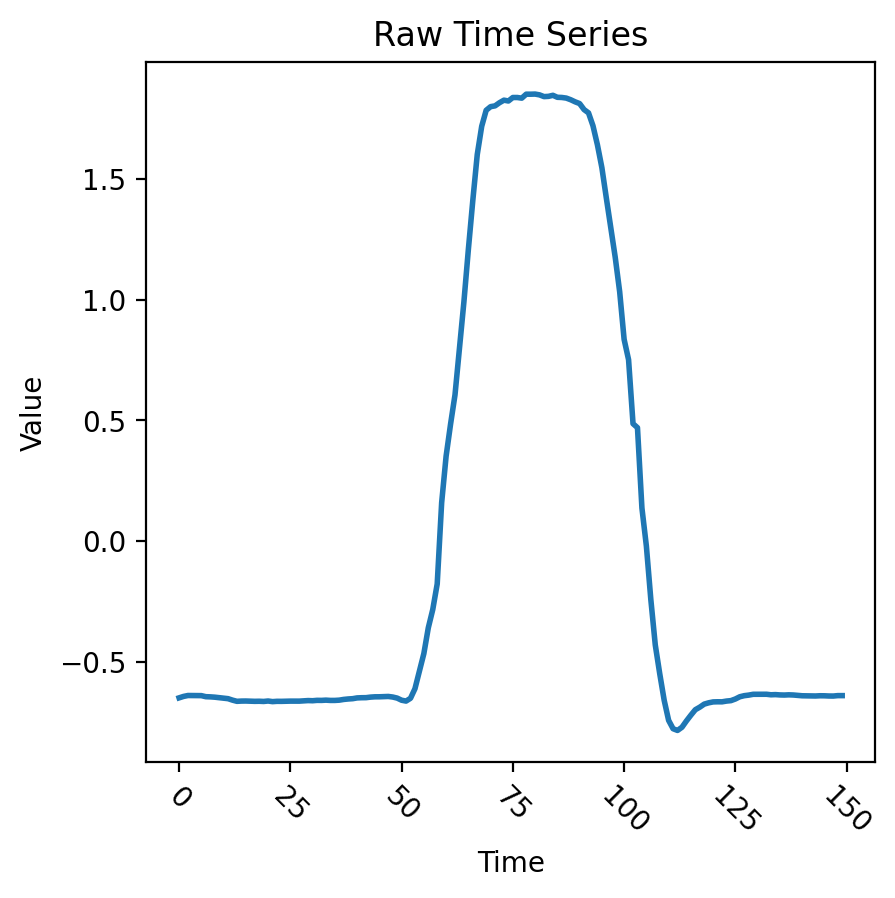

In [12]:

alphabet = ['a','b','c','d']
colors = sns.color_palette("tab10")

print ("Norming")
train = znorm(train)
train = np.array(train)
ts1 = train[0]
print ("Done Norming")

n = len(ts1)
symbols = len(alphabet)

fig = plt.figure(figsize=(16, 10), facecolor='white')
allFeatures = [8,12]

ax = fig.add_subplot(2, len(allFeatures)+1, 1)
ax.set_title("Raw Time Series")                
ax.plot(ts1, lw=2, c=colors[0])
ax.axis('tight')
plt.setp(plt.xticks()[1], rotation=-45)
ax1=ax
ax.set_xlabel('Time')
ax.set_ylabel('Value')


pos = 2
for features in allFeatures:
    paats = paa_transform(ts1, features)
    saxts, thrholds = sax_transform(zts, features, alphabet)
    print (saxts)
    
    minV = min(ts1)
    maxV = max(ts1)
    thrholdsNew = [minV]
    for thr in thrholds:
        thrholdsNew.append(thr)
    
    thrholdsNew.append(maxV)
    thrholdsNew = np.array(thrholdsNew)
    
    ax = fig.add_subplot(2, len(allFeatures)+1, pos, sharex=ax1, sharey=ax1)                
    ax.set_title("SAX, l=" + np.str(features))
    ax.plot(ts1, lw=2, c=colors[0])
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    
    for paa in paats : 
        c = 0    
        value = translate(paa, alphabet, thrholds)    
        for ts_value in value :      
            maxValue = thrholdsNew[ts_value+1]
            minValue = thrholdsNew[ts_value]                   
            
            rect = patches.Rectangle((c,minValue), width=1, height=abs(maxValue-minValue), color=colors[1])
            ax.add_patch(rect)        
            
            c = c+1
    
    ax.axis('tight')
    plt.setp(plot.xticks()[1], rotation=-45)
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    
    text = ''.join(saxts[0]).upper()
    ax.text(0, -2, text, fontsize=26, color = colors[1], weight='bold', family= 'monospace')
    
    print ("Done SAX")
    
    ax = fig.add_subplot(2, len(allFeatures)+1, pos+len(allFeatures)+1, sharex=ax1, sharey=ax1)                
    ax.set_title("SFA, l="+ np.str(features))
    ax.plot(ts1, lw=2, c=colors[0])
    
    
    DFTs = [] 
    for i in range(len(train)) :
         DFTs.append(dft(train[i], features))
    DFTs = np.array(DFTs)
    
    BINs = histogram(DFTs, symbols)
    print ("Histogram", np.shape(BINs))
    
    SFA_SAMPLE = sfaTransform(DFTs[0], BINs)
    upperBounds, lowerBounds = calcInverseSFA(BINs, SFA_SAMPLE, len(ts1))
    xx = np.arange(0, len(ts1))
    plt.plot(xx, upperBounds, lw=2, c=colors[1])
    plt.plot(xx, lowerBounds, lw=2, c=colors[1])
    ax.fill_between(xx, lowerBounds, upperBounds, edgecolor=colors[1], facecolor=colors[1])
    ax.axis('tight')
    plt.setp(plt.xticks()[1], rotation=-45)
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
                
    text = ''.join(map(str,[chr(x+65) for x in SFA_SAMPLE[1:]]))
    ax.text(0, -2, text, fontsize=26, color = colors[1], weight='bold', family= 'monospace')
    
    print ("Done SFA")
    pos = pos +1
    
fig.set_tight_layout(True)

pp = PdfPages('plots/frequency_domain.pdf')
plt.savefig(pp, format='pdf', bbox_inches=None,  facecolor=fig.get_facecolor(), edgecolor='none')
pp.close()

plot.show()